/var/folders/50/fxzc9nm94dnbggn02j9dkwbh0000gn/T/ipykernel_3051/3221723148.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Strength', data=df, palette='viridis')


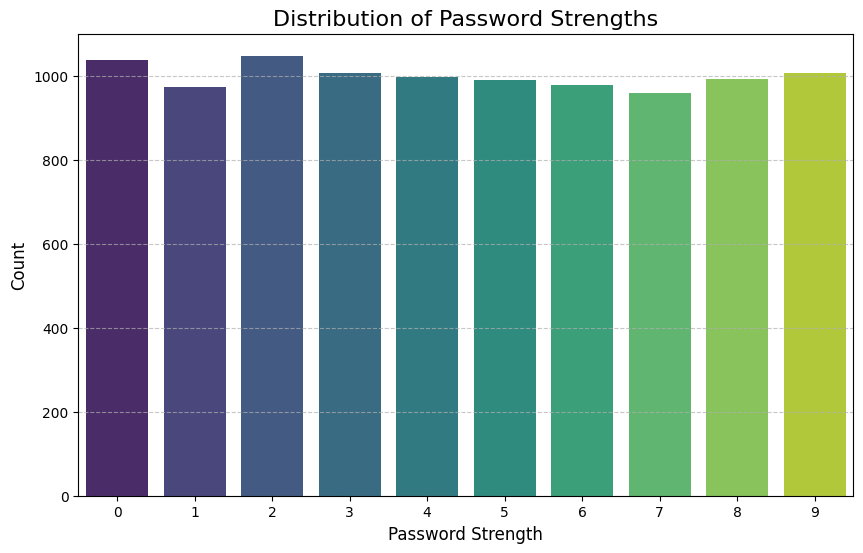

/var/folders/50/fxzc9nm94dnbggn02j9dkwbh0000gn/T/ipykernel_3051/3221723148.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Strength', y='Password_Length', data=df, palette='coolwarm')


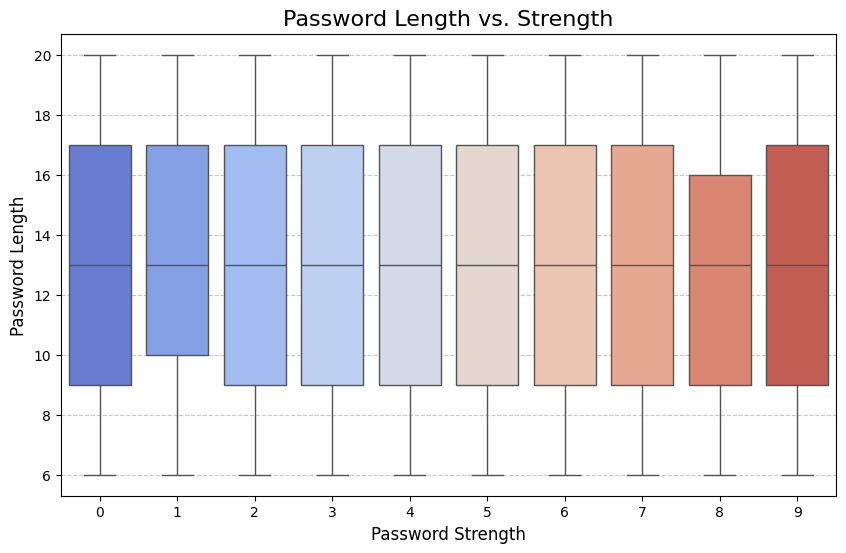

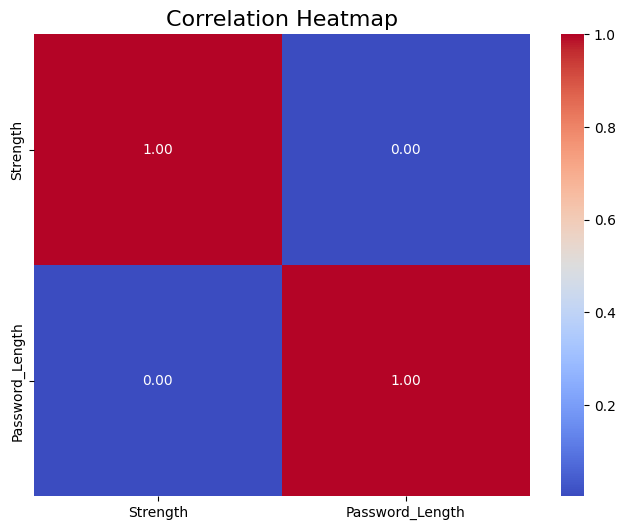

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
file_path = "password_strength_dataset.csv"  # Replace with your dataset path
df = pd.read_csv(file_path)

# Add Password Length column
df['Password_Length'] = df['Password'].apply(len)

# Password Strength Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Strength', data=df, palette='viridis')
plt.title('Distribution of Password Strengths', fontsize=16)
plt.xlabel('Password Strength', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Password Length vs. Strength
plt.figure(figsize=(10, 6))
sns.boxplot(x='Strength', y='Password_Length', data=df, palette='coolwarm')
plt.title('Password Length vs. Strength', fontsize=16)
plt.xlabel('Password Strength', fontsize=12)
plt.ylabel('Password Length', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Correlation Heatmap (numerical columns only)
numerical_cols = ['Strength', 'Password_Length']
plt.figure(figsize=(8, 6))
correlation = df[numerical_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap', fontsize=16)
plt.show()


In [61]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load the dataset (ensure the CSV file is accessible)
data = pd.read_csv('password_strength_dataset.csv')

# Check the number of rows before filtering
print(f"Number of passwords before filtering: {len(data)}")

# Truncate passwords longer than 12 characters and filter out those shorter than 12
data['Password'] = data['Password'].apply(lambda x: x[:12])  # Truncate passwords to 12 characters
data = data[data['Password'].apply(len) == 12]  # Ensure only passwords with length 12 are included

# Check the number of rows after filtering
print(f"Number of passwords after filtering: {len(data)}")

# If no valid passwords are left, raise an error
if len(data) == 0:
    raise ValueError("No valid passwords left after filtering. Check the dataset for passwords of at least 12 characters.")

# Check the distribution of password lengths
print(data['Password'].apply(len).describe())  # Distribution of password lengths
print("Maximum password length:", data['Password'].apply(len).max())  # Max length of passwords

# Create mapping of unique chars to integers
chars = sorted(list(set(''.join(data['Password']))))  # Get unique characters
char_to_int = dict((c, i) for i, c in enumerate(chars))  # Char to int mapping
int_to_char = dict((i, c) for i, c in enumerate(chars))  # Reverse mapping

# Summarize the loaded data
n_chars = sum(data['Password'].apply(len))  # Total number of characters in the dataset
n_vocab = len(chars)  # Total number of unique characters

print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

# Prepare the dataset of input-output pairs encoded as integers
seq_length = 12  # Sequence length
dataX = []
dataY = []
strengths = []

# Generate sequences for passwords of exactly 12 characters
for i, password in enumerate(data['Password']):
    # Since passwords are exactly 12 characters, we can only take the first 11 characters as the sequence input
    seq_in = password[:seq_length - 1]  # Sequence of length 11
    seq_out = password[seq_length - 1]  # Character after the sequence (12th character)
    dataX.append([char_to_int[char] for char in seq_in])  # Map sequence to integers
    dataY.append(char_to_int[seq_out])  # Map the output character to an integer
    strengths.append(data['Strength'].iloc[i])  # Add the strength value for this password

# Check how many valid sequences were generated
print(f"Total valid sequences generated: {len(dataX)}")

# Reshape X to fit LSTM input (samples, time steps, features)
X = np.reshape(dataX, (len(dataX), seq_length - 1, 1))  # Sequence length is 11 (12-1)
X = X / float(n_vocab)  # Normalize X
y_char = to_categorical(dataY)  # One hot encode the character output variable
y_strength = np.array(strengths)  # Strength labels (from 0 to 9)

# Split data into train and test sets
X_train, X_test, y_char_train, y_char_test, y_strength_train, y_strength_test = train_test_split(X, y_char, y_strength, test_size=0.2, random_state=42)

# Define the LSTM model with two outputs (one for character prediction, one for strength)
input_layer = Input(shape=(X.shape[1], X.shape[2]))

lstm_layer = LSTM(256)(input_layer)
dropout_layer = Dropout(0.2)(lstm_layer)

# Character output
char_output = Dense(y_char.shape[1], activation='softmax', name='char_output')(dropout_layer)

# Strength output
strength_output = Dense(10, activation='softmax', name='strength_output')(dropout_layer)  # Strength from 0 to 9

# Create the model
model = Model(inputs=input_layer, outputs=[char_output, strength_output])

# Compile the model
model.compile(optimizer='adam', 
              loss={'char_output': 'categorical_crossentropy', 'strength_output': 'sparse_categorical_crossentropy'},
              metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define a Perplexity Callback
class PerplexityCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the loss from the logs dictionary (categorical cross-entropy)
        loss = logs.get('loss')
        
        if loss is not None:
            # Calculate perplexity
            perplexity = np.exp(loss)
            print(f"Epoch {epoch + 1}: Perplexity = {perplexity}")

# Instantiate the Perplexity callback
perplexity_callback = PerplexityCallback()

# Train the model with the Perplexity callback
model.fit(X_train, {'char_output': y_char_train, 'strength_output': y_strength_train}, epochs=100, batch_size=32, 
          callbacks=[early_stopping, perplexity_callback])

# Pick a random seed for text generation
start = np.random.randint(0, len(dataX) - 1)
pattern = dataX[start]

# Show the seed
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

# Generate characters and predict strength
generated_text = ""
predicted_strength = []

for i in range(12, 20):  # Generate up to 8 characters
    x = np.reshape(pattern, (1, len(pattern), 1))  # Reshape the pattern
    x = x / float(n_vocab)  # Normalize input
    char_prediction, strength_prediction = model.predict(x, verbose=0)  # Predict the next character and strength
    char_index = np.argmax(char_prediction)  # Get the predicted character index
    strength_index = np.argmax(strength_prediction)  # Get the predicted strength index

    result = int_to_char[char_index]  # Convert character index to character
    generated_text += result  # Add predicted character to the result
    predicted_strength.append(strength_index)  # Save the predicted strength value
    
    pattern.append(char_index)  # Append the predicted index to the pattern
    pattern = pattern[1:len(pattern)]  # Shift the pattern

# Show the generated text and strength prediction
print("\nGenerated text:")
print(generated_text)
print(f"Predicted Strength: {predicted_strength[-1]} (on a scale from 0 to 9)")


Number of passwords before filtering: 10000
Number of passwords after filtering: 5981
count    5981.0
mean       12.0
std         0.0
min        12.0
25%        12.0
50%        12.0
75%        12.0
max        12.0
Name: Password, dtype: float64
Maximum password length: 12
Total Characters:  71772
Total Vocab:  94
Total valid sequences generated: 5981
Epoch 1/100


2024-12-20 00:45:22.188106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-20 00:45:22.773109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/150 [..............................] - ETA: 4:33 - loss: 6.8540 - char_output_loss: 4.5428 - strength_output_loss: 2.3112 - char_output_accuracy: 0.0000e+00 - strength_output_accuracy: 0.0312

2024-12-20 00:45:23.166706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - ETA: 0s - loss: 6.8496 - char_output_loss: 4.5442 - strength_output_loss: 2.3054 - char_output_accuracy: 0.0109 - strength_output_accuracy: 0.0976WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,char_output_loss,strength_output_loss,char_output_accuracy,strength_output_accuracy
Epoch 1: Perplexity = 943.5005778234304
150/150 [==============================] - 5s 20ms/step - loss: 6.8496 - char_output_loss: 4.5442 - strength_output_loss: 2.3054 - char_output_accuracy: 0.0109 - strength_output_accuracy: 0.0976
Epoch 2/100
148/150 [============================>.] - ETA: 0s - loss: 6.8452 - char_output_loss: 4.5412 - strength_output_loss: 2.3040 - char_output_accuracy: 0.0125 - strength_output_accuracy: 0.1020WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,char_output_loss,strength_output_loss,char_output_acc

2024-12-20 00:50:03.958661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-20 00:50:04.020754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Generated text:
[D5K2bwO
Predicted Strength: 7 (on a scale from 0 to 9)


In [62]:
# Save the entire model to a file
model.save('password_generation_model.h5')  # You can change the filename to whatever you'd like
print("Model saved to 'password_generation_model.h5'")


Model saved to 'password_generation_model.h5'


/opt/anaconda3/envs/TF_mac_py_38/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [64]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load the dataset (ensure the CSV file is accessible)
data = pd.read_csv('password_strength_dataset.csv')

# Check the number of rows before filtering
print(f"Number of passwords before filtering: {len(data)}")

# Truncate passwords longer than 12 characters and filter out those shorter than 12
data['Password'] = data['Password'].apply(lambda x: x[:12])  # Truncate passwords to 12 characters
data = data[data['Password'].apply(len) == 12]  # Ensure only passwords with length 12 are included

# Check the number of rows after filtering
print(f"Number of passwords after filtering: {len(data)}")

# If no valid passwords are left, raise an error
if len(data) == 0:
    raise ValueError("No valid passwords left after filtering. Check the dataset for passwords of at least 12 characters.")

# Create mapping of unique chars to integers
chars = sorted(list(set(''.join(data['Password']))))  # Get unique characters
char_to_int = {c: i for i, c in enumerate(chars)}  # Char to int mapping
int_to_char = {i: c for i, c in enumerate(chars)}  # Reverse mapping

# Summarize the loaded data
n_chars = sum(data['Password'].apply(len))  # Total number of characters in the dataset
n_vocab = len(chars)  # Total number of unique characters

print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

# Prepare the dataset of input-output pairs encoded as integers
seq_length = 12  # Sequence length
dataX = []
dataY = []
strengths = []

# Generate sequences for passwords of exactly 12 characters
for i, password in enumerate(data['Password']):
    seq_in = password[:seq_length - 1]  # First 11 characters
    seq_out = password[seq_length - 1]  # 12th character
    dataX.append([char_to_int[char] for char in seq_in])  # Map sequence to integers
    dataY.append(char_to_int[seq_out])  # Map the output character to an integer
    strengths.append(data['Strength'].iloc[i])  # Add the strength value for this password

# Reshape X to fit LSTM input (samples, time steps, features)
X = np.reshape(dataX, (len(dataX), seq_length - 1, 1))  # Shape (samples, timesteps, features)
X = X / float(n_vocab)  # Normalize input data
y_char = to_categorical(dataY)  # One-hot encode output characters
y_strength = np.array(strengths)  # Strength labels (0 to 9)

# Split data into train and test sets
X_train, X_test, y_char_train, y_char_test, y_strength_train, y_strength_test = train_test_split(
    X, y_char, y_strength, test_size=0.2, random_state=42
)

# Define the LSTM model with two outputs
input_layer = Input(shape=(seq_length - 1, 1))  # Expecting shape (11, 1)

# LSTM layer
lstm_layer = LSTM(256, return_sequences=False)(input_layer)
dropout_layer = Dropout(0.2)(lstm_layer)

# Character output (next character prediction)
char_output = Dense(y_char.shape[1], activation='softmax', name='char_output')(dropout_layer)

# Strength output (password strength classification)
strength_output = Dense(10, activation='softmax', name='strength_output')(dropout_layer)

# Create the functional model
model = Model(inputs=input_layer, outputs=[char_output, strength_output])

# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'char_output': 'categorical_crossentropy',
        'strength_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'char_output': 'accuracy',
        'strength_output': 'accuracy'
    }
)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define a Perplexity Callback
class PerplexityCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs.get('loss')
        if loss is not None:
            perplexity = np.exp(loss)
            print(f"Epoch {epoch + 1}: Perplexity = {perplexity}")

# Instantiate the Perplexity callback
perplexity_callback = PerplexityCallback()

# Train the model
model.fit(
    X_train,
    {'char_output': y_char_train, 'strength_output': y_strength_train},
    validation_data=(X_test, {'char_output': y_char_test, 'strength_output': y_strength_test}),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, perplexity_callback]
)

# Pick a random seed for text generation
start = np.random.randint(0, len(dataX) - 1)
pattern = dataX[start]

# Show the seed
print("Seed:")
print("\"", ''.join([int_to_char[value] for value in pattern]), "\"")

# Generate characters and predict strength
generated_text = ""
predicted_strength = []

for i in range(12, 20):  # Generate up to 8 characters
    x = np.reshape(pattern, (1, len(pattern), 1))  # Reshape to (1, timesteps, features)
    x = x / float(n_vocab)  # Normalize
    char_prediction, strength_prediction = model.predict(x, verbose=0)
    char_index = np.argmax(char_prediction)  # Get the predicted character index
    strength_index = np.argmax(strength_prediction)  # Get the predicted strength index

    result = int_to_char[char_index]  # Convert character index to character
    generated_text += result  # Add predicted character to the result
    predicted_strength.append(strength_index)  # Save the predicted strength value

    pattern.append(char_index)  # Append the predicted index to the pattern
    pattern = pattern[1:len(pattern)]  # Shift the pattern

# Show the generated text and strength prediction
print("\nGenerated text:")
print(generated_text)
print(f"Predicted Strength: {predicted_strength[-1]} (on a scale from 0 to 9)")


Number of passwords before filtering: 10000
Number of passwords after filtering: 5981
Total Characters:  71772
Total Vocab:  94
Epoch 1/100


2024-12-20 02:20:22.467557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-20 02:20:22.727895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-20 02:20:23.099913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


150/150 [==============================] - ETA: 0s - loss: 6.8502 - char_output_loss: 4.5442 - strength_output_loss: 2.3060 - char_output_accuracy: 0.0111 - strength_output_accuracy: 0.0980

2024-12-20 02:20:27.842582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-20 02:20:27.953766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1: Perplexity = 944.0442089096196
150/150 [==============================] - 7s 36ms/step - loss: 6.8502 - char_output_loss: 4.5442 - strength_output_loss: 2.3060 - char_output_accuracy: 0.0111 - strength_output_accuracy: 0.0980 - val_loss: 6.8459 - val_char_output_loss: 4.5424 - val_strength_output_loss: 2.3035 - val_char_output_accuracy: 0.0150 - val_strength_output_accuracy: 0.1044
Epoch 2/100
150/150 [==============================] - 3s 23ms/step - loss: 6.8449 - char_output_loss: 4.5404 - strength_output_loss: 2.3045 - char_output_accuracy: 0.0115 - strength_output_accuracy: 0.0970 - val_loss: 6.8463 - val_char_output_loss: 4.5442 - val_strength_output_loss: 2.3021 - val_char_output_accuracy: 0.0100 - val_strength_output_accuracy: 0.1044
Epoch 3/100
150/150 [==============================] - 3s 23ms/step - loss: 6.8436 - char_output_loss: 4.5391 - strength_output_loss: 2.3045 - char_output_accuracy: 0.0142 - strength_output_accuracy: 0.0941 - val_loss: 6.8469 - val_char_out

2024-12-20 02:21:04.283621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-20 02:21:04.371932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Generated text:
00000000
Predicted Strength: 1 (on a scale from 0 to 9)


In [65]:
# Save the entire model to a file
model.save('password_generation_model_new.h5')  # You can change the filename to whatever you'd like
print("Model saved to 'password_generation_model_new.h5'")

Model saved to 'password_generation_model_new.h5'


/opt/anaconda3/envs/TF_mac_py_38/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
